<H1> Desafio - SpaceTimeLabs </H1>

# Planejamento

1. [x] Buscar dados: fontes [1] e [2];
2. [x] Importar informações em DataFrame;
3. [x] Tratar informações: extrair datas e normalizar quantidades;
4. [X] Discernir entre quantidades por UF, região política, região econômica e país;  

Esquema proposto para:

Soja: 
```json
    {
        {{filename}}: {
            'dataframe': pd.DataFrame, 
            'tempo': list, 
            'geodados': {
                'Estados': {
                    'dataframe': pd.DataFrame,
                    'dict': dict
                },
                'Regiões políticas': {
                    'dataframe': pd.DataFrame,
                    'dict': dict
                },
                'Regiões econômicas': {
                    'dataframe': pd.DataFrame,
                    'dict': dict
                }, 
                'País': {
                    'dataframe': pd.DataFrame,
                    'dict': dict
                }
            }
        }
    }
```

Clima: `pd.DataFrame`


Dados estão disponíveis nos links abaixo:

- Soja: https://www.conab.gov.br/info-agro/safras/serie-historica-das-safras/itemlist/category/911-soja
- Clima: https://portal.inmet.gov.br/dadoshistoricos

## Preâmbulo - Importações, configurações e definições

### Importações base

In [11]:
from os import getcwd, path, listdir
import os
import shutil
import zipfile

import logging
import ipytest
import pytest

import re
import json
import xlrd
import csv
from urllib.request import urlopen

import sys
from typing import Union, List

from collections import defaultdict

from locale import setlocale, atof, LC_ALL
from locale import str as locale_str

import plotly as plt
import plotly.express as px
from plotly.express import choropleth
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import pandas as pd
import numpy as np

import requests
from zipfile import ZipFile
from tqdm import tqdm

### Configurações base

In [12]:
ipytest.config.magics_flags = ['-qq']
ipytest.autoconfig()

# Define nível logging level para ERROR

# Cria aformatter
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# Cria logger e define nível para DEBUG
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Create a console handler and set the level to DEBUG
ch = logging.StreamHandler(sys.stdout)
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)

import warnings

warnings.filterwarnings(
    'ignore', 
    message="A value is trying to be set on a copy of a slice from a DataFrame."
)


### Utilitários gerais

In [ ]:
def extrair_sheets_de_arquivo_xls(nome_arquivo_soja, pasta_origem, pasta_destino, skip_rows=0):
    """
    Extrai cada planilha de um arquivo Excel e a salva como um arquivo CSV separado.

    Parâmetros:
    - nome_arquivo_soja (str): O nome do arquivo Excel.
    - pasta_origem (str): O caminho para a pasta contendo o arquivo Excel.
    - pasta_destino (str): O caminho para a pasta onde os arquivos CSV serão salvos.
    - skip_rows (int): Número de linhas a serem puladas no início de cada planilha (padrão é 0).
    """
    # Caminho para o arquivo Excel
    caminho_arquivo_excel = os.path.join(pasta_origem, nome_arquivo_soja)

    # Ler o arquivo Excel
    xls = pd.ExcelFile(caminho_arquivo_excel)

    # Obter os nomes das planilhas
    nomes_planilhas = xls.sheet_names

    # Criar a pasta de destino se ela não existir
    os.makedirs(pasta_destino, exist_ok=True)

    # Iterar sobre cada planilha e salvá-la como um arquivo CSV
    nomes_arquivos = []
    for nome_planilha in nomes_planilhas:
        df = pd.read_excel(caminho_arquivo_excel, sheet_name=nome_planilha, skiprows=skip_rows)

        nome_planilha_ = remover_caracteres_especiais(nome_planilha).lower()
        nome_arquivo = f'{nome_planilha_}_soja.csv'
        
        caminho_arquivo_csv = os.path.join(pasta_destino, nome_arquivo)
        
        df.to_csv(caminho_arquivo_csv, index=False)

        print(f'Planilha "{nome_planilha}" salva como arquivo CSV: {caminho_arquivo_csv}')

        nomes_arquivos.append(nome_arquivo)

    return nomes_arquivos

def baixar_e_salvar_arquivo_xls(
    url: str, 
    pasta_destino: str,
    nome_arquivo: str
):
    # Cria a pasta se ela não existir
    if not os.path.exists(pasta_destino):
        os.makedirs(pasta_destino)
    
    # Obtém o nome do arquivo a partir da URL
    caminho_arquivo = os.path.join(pasta_destino, nome_arquivo)
    
    # Baixa o arquivo
    resposta = requests.get(url)
    if resposta.status_code == 200:
        with open(caminho_arquivo, 'wb') as arquivo:
            arquivo.write(resposta.content)
            
        print(f"Arquivo baixado e salvo em: {caminho_arquivo}")

        # Verifica se é um arquivo XLS ou XLSX usando regex
        if re.search(r'\.xls[x]?$', nome_arquivo):
            # Abre o arquivo XLS
            workbook = xlrd.open_workbook(caminho_arquivo)
            # Exemplo de como você pode processar o conteúdo do arquivo XLS
            for sheet_name in workbook.sheet_names():
                sheet = workbook.sheet_by_name(sheet_name)
                
    else:
        print(f"Falha ao baixar o arquivo: {resposta.status_code}")

def quantile1(x):
    return x.quantile(0.25)

def median(x):
    return x.quantile(0.50)

def quantile3(x):
    return x.quantile(0.75)

def inverter_dicionario(dicio: dict):
    dicio_novo = dict()
    
    for chave, valor in dicio.items():
        if(isinstance(valor, list)):
            for el in valor:
                chaves_dicio_novo = list(dicio_novo.keys())
                if(el in chaves_dicio_novo):
                    warn(f'Elemento {el} já tem chave associada {chaves_dicio_novo[el]}. ')
                else:
                    dicio_novo[el] = chave

        else:
            emsg = 'Todos valores do dicionário devem ser listas!'
            raise ValueError(emsg)

    return dicio_novo

def obter_chave_dict(ref_dict: dict, valor):
    candidatos = []
    
    for chave, lista_elementos in ref_dict.items():
        if(isinstance(lista_elementos, list)):
            if(valor in lista_elementos):
                candidatos.append(chave)
            else:
                continue
        else:
            emsg = 'Todos valores do dicionário-referencia devem ser listas!'
            raise ValueError(emsg)

    if(len(candidatos) == 0):
        return None
    if(len(candidatos) == 1):
        return candidatos[0]
    else:
        emsg = 'Apenas uma chave para valor fornecido deve existir!'
        raise ValueError(emsg)

def igualdade_string_relaxada(str1: str, str2: str):
    return str1.lower() == str2.lower()

def normalizar_numeros(number_str):
    # Set the locale to the user's default locale
    setlocale(LC_ALL, '')
    
    # Parse the number-like string to a float
    number = atof(number_str)
    
    # Format the float back to a string using the user's locale
    normalized_number_str = locale_str(number)
    
    return normalized_number_str.replace(',', '.')

def remover_caracteres_especiais(texto):
    from unicodedata import normalize
    import re
    
    # Normalize the text to decomposed form
    text_normalizado = normalize('NFD', texto)
    
    # Use regex to remove non-alphanumeric characters and spaces
    texto_limpo = re.sub(r'[^a-zA-Z0-9\s]', '', text_normalizado)
    
    # Remove extra spaces and return the cleaned text
    return ' '.join(texto_limpo.split())

def cherry_place(lst: list, from_index:int, to_index: int):
    # Remove element at index 2 (3) and store it in a variable
    element = lst.pop(from_index)

      # Insert the element at the specified index
    lst.insert(to_index, element)
    
    return lst

#### Testes - Utilitários gerais

In [59]:
%%ipytest --disable-warnings --color=yes --log-cli-level=info

def test_obter_chave_dict():
    ref_dict = {
        'key1': ['value1', 'value2'],
        'key2': ['value3', 'value4'],
        'key3': ['value5', 'value6']
    }

    # Test case: valid input
    assert obter_chave_dict(ref_dict, 'value3') == 'key2'
    
    # Test case: invalid input (non-list value)
    try:
        obter_chave_dict(ref_dict, 'value1')
    except ValueError as e:
        assert str(e) == 'Apenas uma chave para valor fornecido deve existir!'

    # Test case: invalid input (list value not in dictionary)
    try:
        obter_chave_dict(ref_dict, ['value7', 'value8'])
    except ValueError as e:
        assert str(e) == 'Apenas uma chave para valor fornecido deve existir!'

    # Test case: invalid input (dictionary values are not lists)
    ref_dict_invalid = {
        'key1': 'value1',
        'key2': 'value2'
    }
    
    try:
        obter_chave_dict(ref_dict_invalid, 'value1')
    except ValueError as e:
        assert str(e) == 'Todos valores do dicionário-referencia devem ser listas!'

def test_igualdade_string_relaxada():
    assert igualdade_string_relaxada('abc', 'AbC')
    assert not igualdade_string_relaxada('abcd', 'AbC')

def test_normalizar_numeros():

    # Test with a number-like string using a different locale
    # Modify the number_str and expected_result according to your locale
    number_str = '123.456,789'
    expected_result = '123456.789'
    assert normalizar_numeros(number_str) == expected_result

def test_inverter_dicionario():
    # Test with a dictionary containing lists as values
    dicio = {'a': [1, 2, 3], 'b': [4, 5, 6]}
    expected_result = {1: 'a', 2: 'a', 3: 'a', 4: 'b', 5: 'b', 6: 'b'}
    assert inverter_dicionario(dicio) == expected_result

    # Test with a dictionary containing a non-list value
    dicio = {'a': [1, 2, 3], 'b': 4}  # 'b' has a non-list value
    with pytest.raises(ValueError):
        inverter_dicionario(dicio)

@pytest.fixture
def sample_list():
    return [1, 2, 3, 4, 5]

def test_cherry_place_same_index(sample_list):
    result = cherry_place(sample_list.copy(), 2, 2)
    assert result == [1, 2, 3, 4, 5]

def test_cherry_place_forward(sample_list):
    result = cherry_place(sample_list.copy(), 2, 0)
    assert result == [3, 1, 2, 4, 5]

def test_cherry_place_backward(sample_list):
    result = cherry_place(sample_list.copy(), 0, 2)
    assert result == [2, 3, 1, 4, 5]

def test_cherry_place_end(sample_list):
    result = cherry_place(sample_list.copy(), 0, 4)
    assert result == [2, 3, 4, 5, 1]
    
    result = cherry_place(sample_list.copy(), 0, 10)
    assert result == [2, 3, 4, 5, 1]

def test_cherry_place_out_of_bounds(sample_list):
    with pytest.raises(IndexError):
        cherry_place(sample_list.copy(), 10, 0)

@pytest.fixture
def sample_series():
    return pd.Series([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

def test_quantile1(sample_series):
    result = quantile1(sample_series)
    assert result == 3.25

def test_median(sample_series):
    result = median(sample_series)
    assert result == 5.5

def test_quantile3(sample_series):
    result = quantile3(sample_series)
    assert result == 7.75


t_be641e7449284af3b0aa9863b798256a.py::test_obter_chave_dict PASSED                          [  8%]
t_be641e7449284af3b0aa9863b798256a.py::test_igualdade_string_relaxada PASSED                 [ 16%]
t_be641e7449284af3b0aa9863b798256a.py::test_normalizar_numeros PASSED                        [ 25%]
t_be641e7449284af3b0aa9863b798256a.py::test_inverter_dicionario PASSED                       [ 33%]
t_be641e7449284af3b0aa9863b798256a.py::test_cherry_place_same_index PASSED                   [ 41%]
t_be641e7449284af3b0aa9863b798256a.py::test_cherry_place_forward PASSED                      [ 50%]
t_be641e7449284af3b0aa9863b798256a.py::test_cherry_place_backward PASSED                     [ 58%]
t_be641e7449284af3b0aa9863b798256a.py::test_cherry_place_end PASSED                          [ 66%]
t_be641e7449284af3b0aa9863b798256a.py::test_cherry_place_out_of_bounds PASSED                [ 75%]
t_be641e7449284af3b0aa9863b798256a.py::test_quantile1 PASSED                                 [ 83%]

### Constantes

In [60]:
GITHUBUSERCONTENT_URL = 'https://raw.githubusercontent.com'
ROTA_GEOMETRIA_BRASIL = '/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
URL_GEOMETRIA_BRASIL = f'{GITHUBUSERCONTENT_URL}{ROTA_GEOMETRIA_BRASIL}'

# Source: 
# https://python.plainenglish.io/how-to-create-a-interative-map-using-plotly-express-geojson-to-brazil-in-python-fb5527ae38fc
def obter_geometria_brasil():
    from json import load 
    
    with urlopen(URL_GEOMETRIA_BRASIL) as response:
        return load(response)
    
    return Brazil 

def obter_uf_para_estado(Brazil):
    state_id_map = {}
    for feature in Brazil['features']:
        feature['id'] = feature['properties']['name']
        sigla = feature['properties']['sigla']
        state_id_map[sigla] = feature['id']
    
    return state_id_map

def obter_regiao_para_estado():
    return {
        'NORTE': ['AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO'],
        'NORDESTE': ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
        'CENTRO-OESTE': ['DF', 'GO', 'MT', 'MS'],
        'SUL': ['PR', 'RS', 'SC'],
        'SUDESTE': ['ES', 'MG', 'RJ', 'SP']
    }

def obter_estado_para_regiao():
    return inverter_dicionario(obter_regiao_para_estado())

def obter_estado_para_eregiao():
    return inverter_dicionario(obter_eregiao_para_estado())

def obter_eregiao_para_estado():
    return {
    'NORTE/NORDESTE': [
        'AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO', 'AL', 
        'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'
    ],
    'CENTRO-SUL': [
        'DF', 'GO', 'MT', 'MS', 'PR', 
        'RS', 'SC', 'ES', 'MG', 'RJ', 'SP'
    ]
}

GEOLABELS = [
    [
        'AC', 'AP', 'AM', 'PA', 'RO', 'RR', 
        'TO', 'AL', 'BA', 'CE', 'MA', 'PB', 
        'PE', 'PI', 'RN', 'SE', 'DF', 'GO', 
        'MT', 'MS', 'PR', 'RS', 'SC', 'ES', 
        'MG', 'RJ', 'SP'
    ],
    ['NORTE', 'NORDESTE', 'CENTRO-OESTE', 'SUL', 'SUDESTE'],
    [ 'CENTRO-SUL', 'NORTE/NORDESTE' ]
]

GEOMETRIA_BRAZIL = obter_geometria_brasil()

REGIAO_PARA_ESTADOS = obter_regiao_para_estado()
ESTADOS_PARA_REGIAO = obter_estado_para_regiao()
EREGIAO_PARA_ESTADOS = obter_eregiao_para_estado()
ESTADOS_PARA_EREGIAO = obter_estado_para_eregiao()
SIGLAS_PARA_ESTADOS = obter_uf_para_estado(GEOMETRIA_BRAZIL)

CLIMA_COLUNAS_TEMPO = [
    'DATA (YYYY-MM-DD)', 'Data'
]

CLIMA_COLUNAS_DADOS = [
    'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', 
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'
]

COLUNA_PRECIPITACAO = CLIMA_COLUNAS_DADOS[0]
COLUNA_TEMPERATURA = CLIMA_COLUNAS_DADOS[1]

CLIMA_METRICS = {
    COLUNA_PRECIPITACAO: 'sum',
    COLUNA_TEMPERATURA: ['mean', 'std', quantile1, median, quantile3, 'min', 'max']
}

DELIMITADORES_TEMPO = ['-', '/']
DELIMITADOR_CLIMA = ';'
DELIMITADOR_SOJA = ','

ENCODING_SOJA = 'utf8'
ENCODING_CLIMA = 'latin-1'

ANOS_CLIMA = list(range(2000, 2025))

GEOMARCADORES = [
    'Estados', 'Regiões políticas', 'Regiões econômicas', 'País'
]

SOJA_MARCADORES = GEOMARCADORES
CLIMA_MARCADORES = dict(zip(GEOMARCADORES, GEOLABELS))

# URL do arquivo a ser baixado
URL_DADOS_SOJA = "https://www.conab.gov.br/info-agro/safras/serie-historica-das-safras/item/download/52220_02561b9dfaf9252623ee9876f592aaf4"
URL_DADOS_CLIMA = 'https://portal.inmet.gov.br/uploads/dadoshistoricos/'

## Questão 1

Faça uma **análise histórica** da evolução anual dos valores de:

1. **área plantada**; 
2. **produção**;
3. **produtividade**. 

por estado brasileiro.

Dados disponíveis em: https://www.conab.gov.br/info-agro/safras/serie-historica-das-safras/itemlist/category/911-soja

### Utilitários de ETL

In [64]:
def obter_geodados_soja(
    df_: pd.DataFrame
):
    estados, regioes, regioes_economicas, pais = obter_geolocalizacoes(df_)
    anos = obter_anos(df_)
    
    uf_marcador = df_.columns[0]
    
    mascara_tem_2 = df_[uf_marcador].str.len() == 2
    
    eh_regiao = df_[uf_marcador].isin(regioes)
    eh_eregiao = df_[uf_marcador].isin(regioes_economicas)
    eh_pais = df_[uf_marcador].isin(pais)
    
    mascara_uf = mascara_tem_2
    mascara_regiao = eh_regiao
    mascara_eregiao = eh_eregiao
    mascara_brasil = eh_pais

    df_soja_estados = df_[mascara_uf]
    df_soja_regiao = df_[mascara_regiao]
    df_soja_eregiao = df_[mascara_eregiao]
    df_soja_pais = df_[mascara_brasil]
    
    uf_regiao = ['UF']+anos
    coluna_regiao = ['region']+anos
    coluna_eregiao = ['eregion']+anos
    coluna_pais = ['country']+anos

    df_soja_estados.columns = uf_regiao
    df_soja_regiao.columns = coluna_regiao
    df_soja_eregiao.columns = coluna_eregiao
    df_soja_pais.columns = coluna_pais
    
    return df_soja_estados, df_soja_regiao, df_soja_eregiao, df_soja_pais
    
def tentar_conversao_float_coalescer_zero(
    valor: str
):
    value = str(valor).strip()
    return 0 if valor == '-' else float(valor)
    
def obter_marcador_serie(
    df_: pd.DataFrame, 
    marcador: list
):
    coluna_descritiva = df_.columns[0]
    coluna_nao_descritiva = df_.columns[1:]
    mascara_marcador = df_[coluna_descritiva] == marcador
    
    df_marcador = df_[mascara_marcador]
    
    valores = []
    for linha_id, linha in df_marcador.iterrows():
        valores = [
            tentar_conversao_float_coalescer_zero(linha[col])
            for col in coluna_nao_descritiva
        ]
    
    return valores
    
def obter_marcadores_serie(
    df_: pd.DataFrame, 
    marcadores: list
):
    anos = [
        int(valor) 
        for valor in df_.columns[1:]
    ]
    
    return {
        marcador: obter_marcador_serie(df_, marcador) 
        for marcador in marcadores
    } 

def obter_anos(
    df_: pd.DataFrame
):
    return [
        int(year.split('/')[0]) 
        for year in df_.columns[1:]
    ]

def obter_geolocalizacoes(
    df_: pd.DataFrame
):
    uf_marcador = df_.columns[0]
    
    mascara_tem_2 = df_[uf_marcador].str.len() == 2
    mascara_nao_tem_2 = df_[uf_marcador].str.len() != 2
    
    lista_regioes = list(df_[mascara_nao_tem_2][uf_marcador])
    
    estados = list(df_[mascara_tem_2][uf_marcador])
    regioes = lista_regioes[0:5]
    regioes_economicas = lista_regioes[5:7]
    pais = [lista_regioes[7]]
    
    return estados, regioes, regioes_economicas, pais

def carregar_dados_soja(
    rota_absoluta_arquivo: str
):
    return pd.read_csv(
        rota_absoluta_arquivo, 
        delimiter=DELIMITADOR_SOJA, 
        encoding=ENCODING_SOJA
    )

def transpor_geodados_soja(df_: pd.DataFrame):
    df_ = df_.copy(deep=True)
    
    # 1. Seta coluna nao numerica como index
    geo_index=[
        col 
        for col in df_.columns 
        if not isinstance(col, int)
    ][0]
    
    df_.set_index(geo_index, inplace=True)
    
    # 2. Transpoem DataFrame
    df_ = df_.transpose()
    
    # 3. Reseta indice
    df_.reset_index(inplace=True)
    
    # 4. Renomea 'UF' para 'anos'
    df_.rename(columns={'index': 'anos'}, inplace=True)
    
    df_.columns.name = None

    return df_

def montar_geodados_soja(
    geodado: pd.DataFrame, 
    geomarcadores: list
):
    df_geodados_soja = transpor_geodados_soja(geodado)
    
    return {
        'dataframe': df_geodados_soja,
        'dict': obter_marcadores_serie(geodado, geomarcadores)
    }

def montar_dados_soja(
    df_: pd.DataFrame
):
    return {
        geo_marcador: montar_geodados_soja(geodado, geolocalizacao)
        for geo_marcador, 
            geodado, 
            geolocalizacao in zip(
            GEOMARCADORES, 
            obter_geodados_soja(df_), 
            obter_geolocalizacoes(df_)
        )
    }

def validar_nome_arquivo(
    fname: str
):
    splitted_fname = fname.split('.')
    return splitted_fname[-1].lower() == 'csv'

def validar_nomes_arquivos(
    nome_arquivos: list
):
    from numpy import where, array
    
    validation_arr = []
    
    for nome_arquivo in nome_arquivos:
        validation_arr.append(validar_nome_arquivo(nome_arquivo))
    
    are_false = array(validation_arr) == False
    are_false_indexes = list(where(are_false)[0])
    
    if(len(are_false_indexes) != 0):
        false_elems = [nome_arquivos[index] for index in are_false_indexes]

        false_msg = '\n'.join(false_elems)
        error_message = f'Arquivos abaixo são inválidos:\n{false_msg}'
        
        raise ValueError(error_message)

def obter_dados_soja(
    rota_origem: str, 
    nome_arquivos: list
):
    validar_nomes_arquivos(nome_arquivos)

    dados_soja = dict()
    
    for nome_arquivo in nome_arquivos:
        df_soja = carregar_dados_soja(rota_origem+nome_arquivo)
        rota_arquivo = rota_origem+nome_arquivo
        chave_ = nome_arquivo.split('.')[0]

        dados_soja[chave_] = {
            'dataframe': df_soja, 
            'tempo': obter_anos(df_soja), 
            'geodados': montar_dados_soja(df_soja)
        }

    return dados_soja

def obter_geodados_por_geomarcador(dados_dict: dict, geomarcador: str):
    dados_chaves = dados_dict.keys()

    geodados_lista = []
    for dados_coluna in dados_chaves:
        df_ = dados_dict[dados_coluna]['geodados'][geomarcador]['dataframe']
        geodados_lista.append(df_ )

    return geodados_lista

def plotar_geodados_interativo_soja(
    geodados_lista: list,
    titulo:str, subplot_titles: list, ylabels: list,
    eh_empilhado: bool = True
):
    
    # Create subplots
    fig = make_subplots(rows=1, cols=3, subplot_titles=subplot_titles)
    
    # Add stacked area plots to subplots
    for idx, geodados_elem in enumerate(geodados_lista):
        data_labels = [
            col 
            for col in geodados_elem.columns 
            if col != 'anos'
        ]

        for enum_val, data_label in enumerate(data_labels):
            if eh_empilhado:
                fill_label = 'tozeroy' if enum_val == 0 else 'tonexty'
            else:
                fill_label = 'tozeroy'
            
            x = geodados_elem['anos']
            y = geodados_elem[data_label]

            scatter_data = go.Scatter(
                x=x, y=y, 
                fill= fill_label, name=data_label, stackgroup='one',
                showlegend = False
            )

            fig.update_xaxes(title_text='Tempo [anos]', row=1, col=idx+1)
            fig.update_yaxes(title_text=ylabels[idx], row=1, col=idx+1)
            fig.add_trace(scatter_data, row=1, col=idx+1)

    # Update layout
    fig.update_layout(showlegend=True, hovermode='x', title=titulo)
    
    # Show plot
    fig.show()

def plotar_dados_soja(
    marcador: str, 
    x: np.ndarray, 
    y_dict: dict, 
    y_marcador: str
):
    import matplotlib.pyplot as plt 
    
    fig = plt.figure(figsize=(10, 8))

    # Stacked area plot
    plt.title('Acumulada')
    plt.stackplot(x, y_dict.values(), labels=y_dict.keys())

    plt.xlabel('Tempo [Anos]')
    plt.ylabel(y_marcador)
    plt.legend(title='Legend', loc='upper left')

    plt.suptitle(f'{y_marcador} por {marcador}')
    plt.tight_layout()
    plt.show()

### Extracao e transformação

In [65]:
# Path to your Excel file
rota_raiz = getcwd()
rota_pasta_soja = 'data/soja/'
nome_arquivo_soja = 'SojaSerieHist.xls'

rota_pasta = path.join(rota_raiz, rota_pasta_soja)
rota_arquivo = path.join(rota_pasta, nome_arquivo_soja)

baixar_e_salvar_arquivo_xls(URL_DADOS_SOJA, rota_pasta, nome_arquivo_soja)

nome_arquivo = nome_arquivo_soja
pasta_origem = rota_raiz+'/'+rota_pasta_soja
pasta_destino = rota_raiz+'/'+rota_pasta_soja
skip_rows = 5

nome_arquivos = extrair_sheets_de_arquivo_xls(nome_arquivo_soja, pasta_origem, pasta_destino, skip_rows)
dados_soja = obter_dados_soja(rota_pasta_soja, nome_arquivos)

Arquivo baixado e salvo em: /home/brunolnetto/github/dashoy/pesquisa/data/soja/SojaSerieHist.xls
Planilha "Área" salva como arquivo CSV: /home/brunolnetto/github/dashoy/pesquisa/data/soja/area_soja.csv
Planilha "Produtividade" salva como arquivo CSV: /home/brunolnetto/github/dashoy/pesquisa/data/soja/produtividade_soja.csv
Planilha "Produção" salva como arquivo CSV: /home/brunolnetto/github/dashoy/pesquisa/data/soja/producao_soja.csv


### Visualização

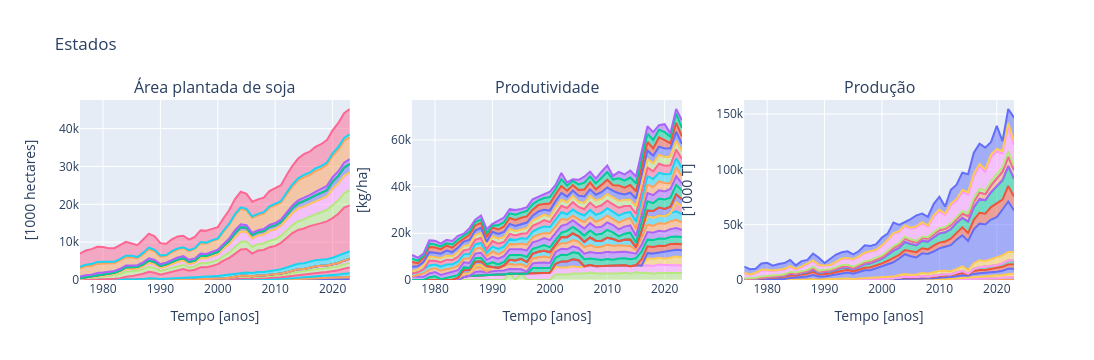

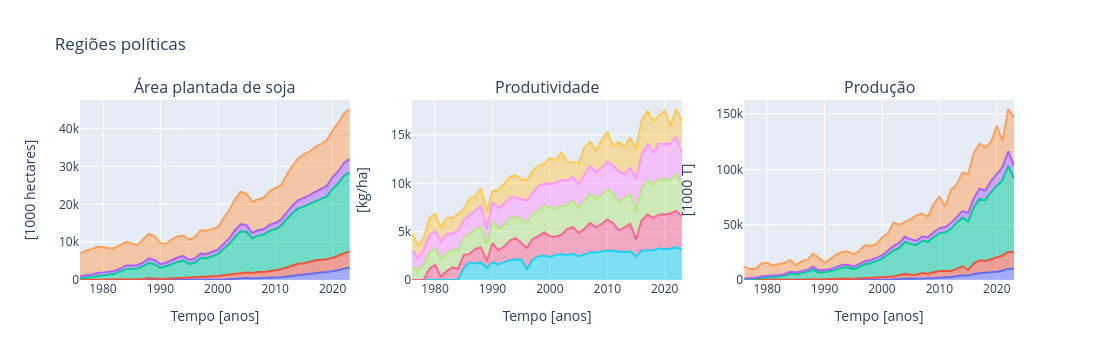

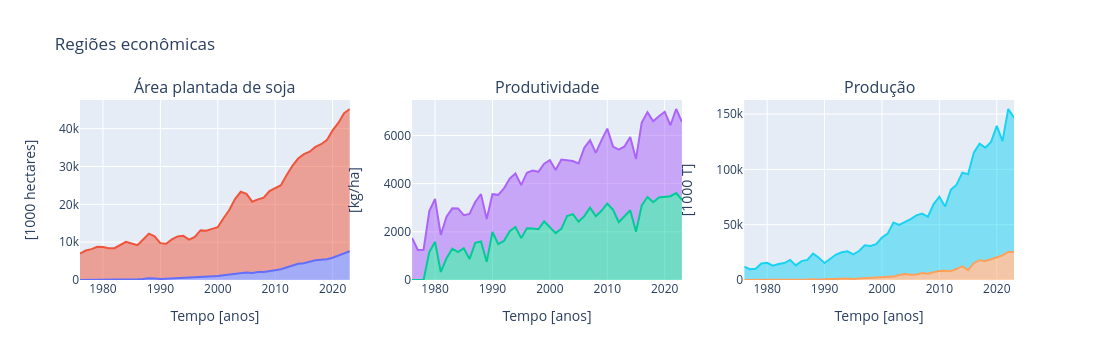

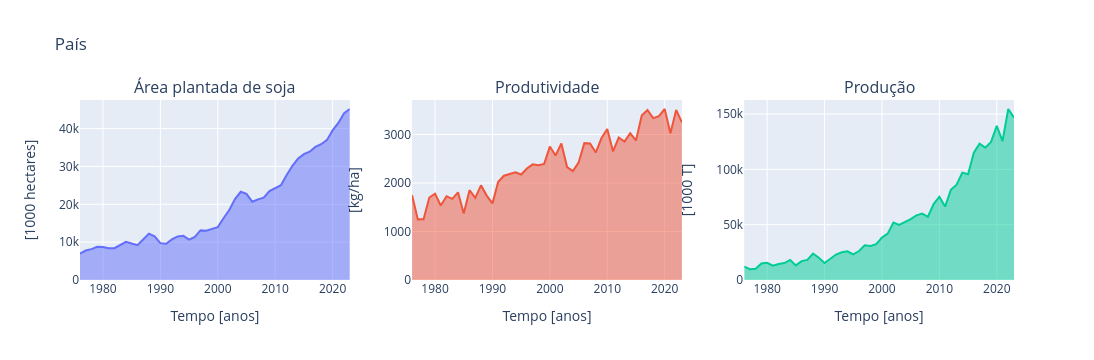

In [66]:
for geomarcador in GEOMARCADORES:
    dfs = obter_geodados_por_geomarcador(dados_soja, geomarcador)
    
    ylabels = [
        '[1000 hectares]', 
        '[kg/ha]', 
        '[1000 T]'
    ]
    
    subplot_labels = [
        'Área plantada de soja', 
        'Produtividade', 
        'Produção'
    ]
    
    dfs = obter_geodados_por_geomarcador(dados_soja, geomarcador)
    
    titulo = geomarcador
    
    plotar_geodados_interativo_soja(dfs, titulo, subplot_labels, ylabels, True)


## Questão 2

Faça um **cruzamento dos dados históricos de produtividade de soja com dados históricos climáticos** (principalmente temperatura e precipitação). 

Avalie a existência de correlações entre fatores climáticos e produtividade de soja.

Dados disponíveis em: https://portal.inmet.gov.br/dadoshistoricos

Janela de tempo: [2000, 2024]

### Utilitários de ETL

#### Funções

In [67]:
from warnings import warn

def percorrer_e_mover_pastas(pasta_raiz, eh_verbose=False):
    # Obter a lista de todas as subpastas
    subpastas = [f.path for f in os.scandir(pasta_raiz) if f.is_dir()]
    
    # Percorrer cada subpasta
    for subpasta in subpastas:
        # Usar a subpasta como nova pasta raiz
        percorrer_e_mover_pastas(subpasta)
        
        # Obter a lista de todos os arquivos na subpasta
        arquivos = [f.path for f in os.scandir(subpasta) if f.is_file()]
        
        # Mover cada arquivo para a pasta raiz atual
        for caminho_arquivo in arquivos:
            nome_arquivo = os.path.basename(caminho_arquivo)
            novo_caminho_arquivo = os.path.join(pasta_raiz, nome_arquivo)
            # Check if the file already exists in the destination directory
            if os.path.exists(novo_caminho_arquivo):
                # Rename the file
                nome_arquivo, extensao = os.path.splitext(nome_arquivo)
                contador = 1
                while True:
                    novo_nome_arquivo = f"{nome_arquivo}_{contador}{extensao}"
                    novo_caminho_arquivo = os.path.join(pasta_raiz, novo_nome_arquivo)
                    if not os.path.exists(novo_caminho_arquivo):
                        break
                    contador += 1

                if(eh_verbose):
                    print(f"Arquivo renomeado para {novo_nome_arquivo}")
            
            # Move the file to the destination directory
            shutil.move(caminho_arquivo, novo_caminho_arquivo)
            
            if(eh_verbose):
                print(f"Arquivo movido de {caminho_arquivo} para {novo_caminho_arquivo}")
        
        # Remover a subpasta
        os.rmdir(subpasta)
        if(eh_verbose):
            print(f"Subpasta removida: {subpasta}")

def download_e_salvar_zip(url, folder_path, file_name, eh_verbose=False):
    # Cria a pasta se ela não existir
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    # Caminho completo do arquivo
    file_path = os.path.join(folder_path, file_name)
    
    # Baixa o arquivo
    with urlopen(url) as response, open(file_path, 'wb') as file:
        file.write(response.read())
    
    if(eh_verbose):
        print(f"Arquivo ZIP baixado e salvo em: {file_path}")
    
    # Extrai o arquivo
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        # Obtém o nome da pasta para extrair o conteúdo do arquivo
        folder_name = os.path.splitext(file_name)[0]
        extract_path = os.path.join(folder_path, folder_name)
        
        zip_ref.extractall(extract_path)
    
    if(eh_verbose):
        print(f"Conteúdo do arquivo ZIP extraído em: {extract_path}")
    
    # Deleta o arquivo ZIP
    os.remove(file_path)
    if(eh_verbose):
        print(f"Arquivo ZIP deletado: {file_path}")

def obter_arquivos_csv_clima(rota_clima):
    from os import listdir
    arquivos_clima = listdir(rota_clima)
    
    return [
        arquivo_clima
        for arquivo_clima in arquivos_clima
        if igualdade_string_relaxada(
            arquivo_clima.split('.')[-1], 
            'csv'
        )
    ] 

def obter_uf_pelo_arquivo_clima(climate_file_):
    return climate_file_.split('_')[2]

def obter_ufs_pela_rota_base(rota_clima):
    arquivos_clima = obter_arquivos_csv_clima(rota_clima)
    
    return list(
        {
            obter_uf_pelo_arquivo(arquivo_clima) 
            for arquivo_clima in arquivos_clima
        }
    )

def obter_anos_pela_rota_base(rota_clima):
    return [int(ano) for ano in listdir(rota_clima)]

def normalizar_dataframe_clima(df_):
    str_para_float = lambda x: float(str(x).replace(',', '.'))
    normalizar_str = lambda x: float(str_para_float(normalizar_numeros(str(x))))
    
    df_[COLUNA_TEMPERATURA] = df_[COLUNA_TEMPERATURA].apply(str_para_float)
    df_[COLUNA_PRECIPITACAO] = df_[COLUNA_PRECIPITACAO].apply(normalizar_str)

    precipitacao_has_9999_float = df_[COLUNA_PRECIPITACAO] > 0
    temperatura_has_9999_float = df_[COLUNA_TEMPERATURA] > -50

    cleanse_mask = precipitacao_has_9999_float & temperatura_has_9999_float
        
    return df_[cleanse_mask]

def obter_dados_clima(rota_fonte, skiprows=8):
    df_ = pd.read_csv(
        rota_fonte, 
        skiprows=skiprows,  
        delimiter=DELIMITADOR_CLIMA, 
        encoding=ENCODING_CLIMA
    )
    
    # Reset the index
    df_.reset_index(drop=True, inplace=True)
    
    return normalizar_dataframe_clima(df_)

def adicionar_ano_a_dataframe_clima(df_: pd.DataFrame):
    df = df_.copy()  # Create a copy of the DataFrame
    col_tempo = df_.columns[0]
    split_map = lambda x: float(re.split('|'.join(map(re.escape, DELIMITADORES_TEMPO)), str(x))[0])
    df['ano'] = df_[col_tempo].apply(split_map)
    
    return df

def adicionar_mes_a_dataframe_clima(df_: pd.DataFrame):
    df = df_.copy()  # Create a copy of the DataFrame
    col_tempo = df_.columns[0]
    split_map = lambda x: float(re.split('|'.join(map(re.escape, DELIMITADORES_TEMPO)), str(x))[1])
    df['mes'] = df_[col_tempo].apply(split_map)
    
    return df

def adicionar_uf_a_dataframe_clima(
    df_: pd.DataFrame,
    uf_clima: str
):
    df_['UF'] = uf_clima
    df_len = len(df_.columns)
    columns = list(df_.columns)
    colunas_novas = cherry_place(columns, df_len-1, 2)
    df_ = df_[colunas_novas]
    
    return df_

def remover_coluna_unnamed(
    df_: pd.DataFrame
):
    coluna_unnamed = [ 
        col
        for col in df_.columns
        if col.lower().find('unnamed') != -1
    ][0]
    
    df_.drop(coluna_unnamed, axis=1)

    return df_

def transformar_dataframe_clima(
    df_: pd.DataFrame,
    arquivo_clima: str
):
    uf_clima = obter_uf_pelo_arquivo_clima(arquivo_clima)
    df_ = adicionar_uf_a_dataframe_clima(df_, uf_clima)
    
    df_ = adicionar_ano_a_dataframe_clima(df_)
    df_ = adicionar_mes_a_dataframe_clima(df_)
    remover_coluna_unnamed(df_)
    
    return df_

def agrupar_dataframe_clima(
    df_: pd.DataFrame
):
    col_precipitacao = CLIMA_COLUNAS_DADOS[0]
    col_temperatura = CLIMA_COLUNAS_DADOS[1]
    
    colunas_grupo = ['ano', 'UF']
    
    # Use the metrics dictionary in the groupby aggregation
    result = df_.groupby(colunas_grupo).agg(CLIMA_METRICS)
    
    # Flatten the column index
    result.columns = ['_'.join(col).strip() for col in result.columns.values]
    
    result = result.reset_index()
    
    return result


### Extração

In [ ]:
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from urllib.request import urlopen
import shutil

def tarefa_obter_dados_clima(url, folder_path, ano):
    file_name = f'{ano}.zip'
    file_folder = folder_path+'/'+file_name.split('.')[0] 
    
    download_e_salvar_zip(url, folder_path, file_name)

    file_folder = os.path.join(folder_path, f'{ano}')
    percorrer_e_mover_pastas(file_folder)

folder_path = os.path.join(os.getcwd(), 'data', 'clima')

# Create the folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

with ThreadPoolExecutor() as executor:
    futures = []
    for ano in ANOS_CLIMA:
        file_name = str(ano) + '.zip'
        url = URL_DADOS_CLIMA + file_name
        futures.append(
            executor.submit(
                tarefa_obter_dados_clima, 
                url, folder_path, ano
            )
        )
    
    # Use tqdm to create a progress bar
    for future in tqdm(
        as_completed(futures), 
        total=len(futures), 
        desc="Downloading files"
    ):
        future.result()  # Wait for the download to complete
    

In [76]:
anos = ANOS_CLIMA

for ano in tqdm(anos):
    file_name = f'{ano}.zip'
    folder_path = getcwd()+'/data/clima'
    file_folder = folder_path+'/'+file_name.split('.')[0] 
    
    url = URL_DADOS_CLIMA+file_name

    download_e_salvar_zip(url, folder_path, file_name)
    percorrer_e_mover_pastas(file_folder)

100%|███████████████████████████████████████████| 25/25 [04:55<00:00, 11.82s/it]


['2016',
 '2014',
 '2006',
 '2023',
 '2003',
 '2017',
 '2000',
 '2007',
 '2013',
 '2022',
 '2020',
 '2001',
 '2024',
 '2004',
 '2005',
 '2015',
 '2019',
 '2008',
 '2009',
 '2021',
 '2012',
 '2018',
 '2011',
 '2010',
 '2002']

In [80]:
rota_clima

'/home/brunolnetto/github/dashoy/pesquisa/data/clima/2002'

In [81]:
listdir(rota_clima)

['INMET_CO_GO_A003_MORRINHOS_01-01-2002_A_31-12-2002.CSV',
 'INMET_CO_MS_A703_PONTA PORA_01-01-2002_A_31-12-2002.CSV',
 'INMET_SE_SP_A706_CAMPOS DO JORDAO_13-03-2002_A_31-12-2002.CSV',
 'INMET_CO_MS_A702_CAMPO GRANDE_01-01-2002_A_31-12-2002.CSV',
 'INMET_SE_MG_A505_ARAXA_19-12-2002_A_31-12-2002_1.CSV',
 'INMET_CO_MT_A902_TANGARA DA SERRA_11-12-2002_A_31-12-2002.CSV',
 'INMET_S_RS_A801_PORTO ALEGRE_01-01-2002_A_31-12-2002.CSV',
 'INMET_SE_MG_A506_MONTES CLAROS_19-12-2002_A_31-12-2002_1.CSV',
 'INMET_CO_MS_A704_TRES LAGOAS_01-01-2002_A_31-12-2002_1.CSV',
 'INMET_SE_RJ_A602_MARAMBAIA_08-11-2002_A_31-12-2002_1.CSV',
 'INMET_SE_RJ_A604_CAMBUCI_20-11-2002_A_31-12-2002.CSV',
 'INMET_SE_MG_A502_BARBACENA_05-12-2002_A_31-12-2002_1.CSV',
 'INMET_S_RS_A805_SANTO AUGUSTO_01-01-2002_A_31-12-2002_1.CSV',
 'INMET_SE_MG_A507_UBERLANDIA_18-12-2002_A_31-12-2002_1.CSV',
 'INMET_S_RS_A801_PORTO ALEGRE_01-01-2002_A_31-12-2002_1.CSV',
 'INMET_S_RS_A802_RIO GRANDE_01-01-2002_A_31-12-2002_1.CSV',
 'INMET_SE_M

In [ ]:
from tqdm import tqdm

rota_base_clima = os.path.join(getcwd(), 'data', 'clima')

anos_clima = obter_anos_pela_rota_base(rota_base_clima)

rotas_clima = [
    os.path.join(rota_base_clima, str(ano_clima))
    for ano_clima in anos_clima
] 

clima_anos_df = {
    ano: None
    for ano in anos_clima
}

total_arq = sum(
    len(listdir(rota_clima)) 
    for rota_clima in rotas_clima
)

print(f"Total de arquivos a processar: {total_arq}")

i = 0
ano_rota_clima_list = list(zip(anos_clima, rotas_clima))
for ano_clima, rota_clima in ano_rota_clima_list:
    arquivos_clima = listdir(rota_clima)
    
    df_ano_clima = pd.DataFrame()
    for arquivo_clima in tqdm(arquivos_clima):
        rota_fonte_dados = path.join(rota_clima, arquivo_clima)
        
        try:
            df_ = obter_dados_clima(rota_fonte_dados)
            df_ = transformar_dataframe_clima(df_, arquivo_clima)
            
            df_ano_clima = pd.concat([df_, df_ano_clima])
        except Exception as e:
            logging.error(f'Erro na leitura do arquivo {rota_fonte_dados}: {e}', exc_info=True)

        i = i + 1

    clima_anos_df[ano_clima] = df_ano_clima


Total de arquivos a processar: 12545


 53%|█████████████████████▊                   | 499/936 [01:17<01:18,  5.58it/s]

In [ ]:
anos = clima_anos_df.keys()

clima_total_df = pd.DataFrame()

for ano in anos:
    clima_total_df = pd.concat([clima_total_df, clima_anos_df[ano]])


In [102]:
def obter_sumario_regiao_clima(
    df_estados: pd.DataFrame    
):
    df_regiao = clima_total_df.copy()
    para_regiao = lambda x: ESTADOS_PARA_REGIAO[x]
    df_regiao['UF'] = df_regiao['UF'].apply(para_regiao)

    return agrupar_dataframe_clima(df_regiao)

def obter_sumario_eregiao_clima(
    df_estados: pd.DataFrame    
):
    df_eregiao = df_estados.copy()
    para_eregiao = lambda x: ESTADOS_PARA_EREGIAO[x]
    df_eregiao['UF'] = df_eregiao['UF'].apply(para_eregiao)

    return agrupar_dataframe_clima(df_eregiao)

def obter_sumario_pais_clima(
    df_estados: pd.DataFrame    
):
    df_pais = df_estados.copy()
    df_pais['UF'] = 'Brasil'

    return agrupar_dataframe_clima(df_pais)

def obter_sumario_geoclima(
    df_estados: pd.DataFrame
):
    dataframes_clima = (
        agrupar_dataframe_clima(df_estados), \
        obter_sumario_regiao_clima(df_estados), \
        obter_sumario_eregiao_clima(df_estados), \
        obter_sumario_pais_clima(df_estados)
    )

    geo_dataframes_zip = zip(GEOMARCADORES, dataframes_clima)
    return dict(geo_dataframes_zip)

def plotar_dados_clima(
    df_: pd.DataFrame,
    geolabel: str
):
    # Create subplots
    fig = make_subplots(
        rows=1, cols=2, 
        subplot_titles=('Rain Quantity', 'Temperature')
    )
    
    # Rain Quantity subplot
    dados_chuva = {
        'x': df_['ano'], 
        'y': df_['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)_sum'], 
        'marker_color': 'blue'
    }
    
    bar = go.Bar(dados_chuva)
    
    fig.add_trace(bar, row=1, col=1)
    fig.update_xaxes(title_text='Year', row=1, col=1)
    fig.update_yaxes(title_text='Rain Quantity (mm) - ', row=1, col=1)
    
    # Temperature subplot with error bars
    x = df_['ano']
    y = df_['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)_mean']
    median = df_['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)_median']
    q1 = df_['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)_quantile1']
    q3 = df_['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)_quantile3']
    error_values = dict(type='data', symmetric=False, array=median-q1, arrayminus=q3-median)
    
    dados_temperatura = {
        'x': x,
        'y': y,
        'error_y': error_values,
        'mode':'lines+markers', 
        'marker_color':'red', 
        'name':'Mean Temperature'
    }
    
    scatter = go.Scatter(dados_temperatura)
    
    fig.add_trace(scatter, row=1, col=2)
    fig.update_xaxes(title_text='Year', row=1, col=2)
    fig.update_yaxes(title_text='Temperature (°C)', row=1, col=2)
    
    fig.update_layout(
        title=f'Precipitação e Temperatura - {geolabel}', 
        showlegend=False
    )
    fig.show()

def plotar_estado_clima(df, geolabel):
    geolabel = geolabels[idx]

    mask = df_orig['UF'] == geolabel
    df = df_orig[mask]
    
    geolabel = SIGLAS_PARA_ESTADOS[geolabel]
    
    plotar_dados_clima(df, geolabel)

In [ ]:
file_path = getcwd()+'/data/dados_clima.csv'

clima_total_df.to_csv(file_path)


In [104]:
file_path = getcwd()+'/data/dados_clima.csv'

clima_total_df = pd.read_csv(file_path, low_memory=False)
resumo_clima = obter_sumario_geoclima(clima_total_df)

In [114]:
geo_descricoes = list(resumo_clima.values())

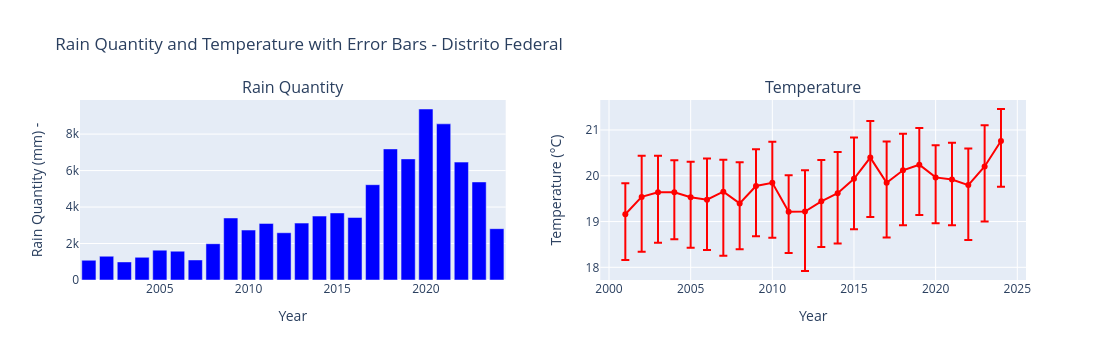

In [116]:
df_orig = geo_descricoes[0]

idx = 10
geolabels = list(df_orig['UF'])
plotar_estado_clima(df, geolabel)


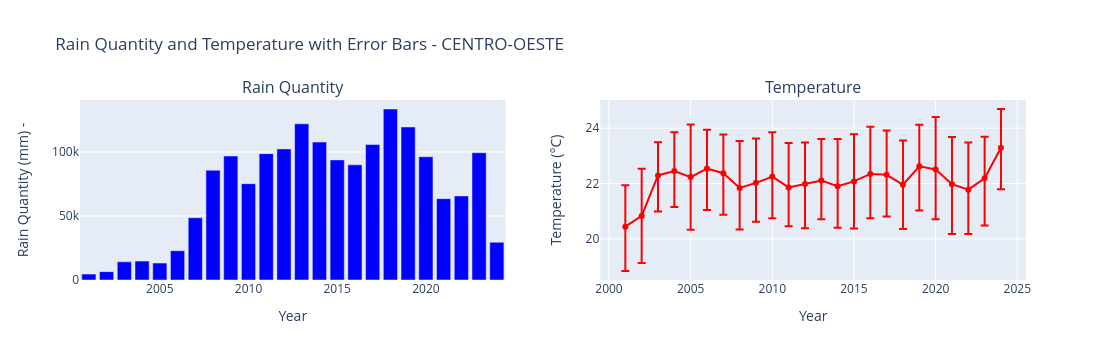

In [117]:
df_orig = geo_descricoes[1]

idx = 2
geolabels = list(df_orig['UF'])
geolabel = geolabels[0]

mask = df_orig['UF'] == geolabel
df = df_orig[mask]

plotar_dados_clima(df, geolabel)
    

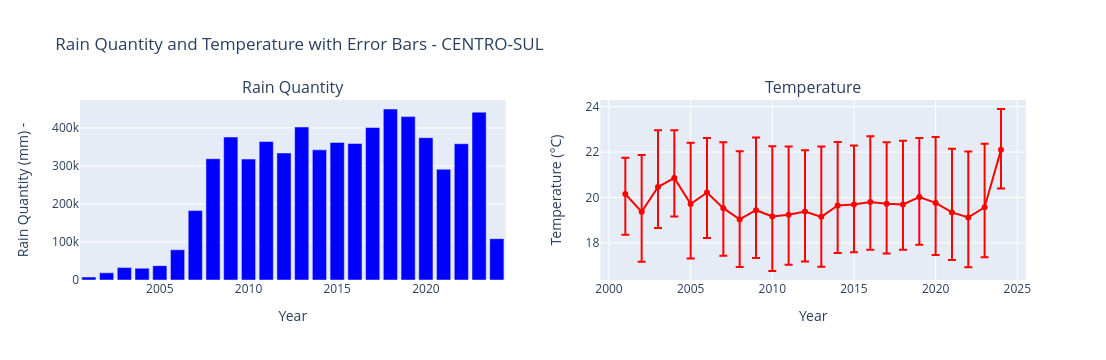

In [118]:
df_orig = geo_descricoes[2]

idx = 2
geolabels = list(df_orig['UF'])
geolabel = geolabels[0]

mask = df_orig['UF'] == geolabel
df = df_orig[mask]

plotar_dados_clima(df, geolabel)

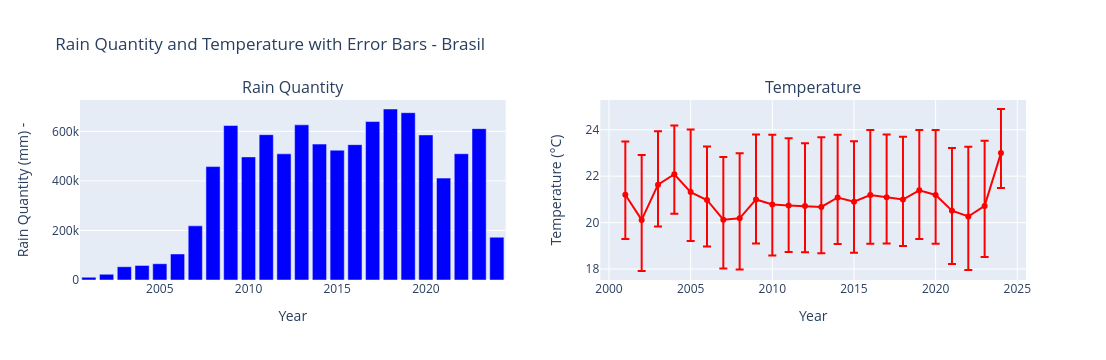

In [119]:
df_orig = geo_descricoes[3]

idx = 2
geolabels = list(df_orig['UF'])
geolabel = geolabels[0]

mask = df_orig['UF'] == geolabel
df = df_orig[mask]

plotar_dados_clima(df, geolabel)

## Questão 3

Elabore um ou mais painéis demonstrando, de forma resumida, as análises e conclusões dos itens anteriores. Recomenda-se que os painéis contenham elementos variados, como, por exemplo:

- mapas coropléticos dos estados brasileiros, representando algumas das grandezas
analisadas
- gráficos de séries temporais
- gráficos de distribuição

Fonte: https://github.com/brunolnetto/dashoy


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Certifique-se de ter o arquivo "BR_UF_2021.shp" em seu diretório ou ajuste o caminho conforme necessário
shapes_path = getcwd()+"/shapes/BR_UF_2022.shp"
estados = gpd.read_file(shapes_path)

# Substitua "data" pelo seu DataFrame contendo os dados para a coropleta
# Substitua "column" pelo nome da coluna contendo os dados a serem visualizados
estados.plot(cmap="OrRd", legend=True, figsize=(12, 8))

plt.title("Unidades da federação")
plt.axis("off")

plt.show()

In [ ]:
state_id_map = {}
for feature in Brazil['features']:
 feature['id'] = feature['properties']['name']
 sigla = feature['properties']['sigla']
 state_id_map[sigla] = feature['id']

route='/nayanemaia/Dataset_Soja/main/soja%20sidra.csv'
soybean = pd.read_csv(f'{githubusercontent_url}{route}')

fig = choropleth(
 soybean,                                           #   soybean database
 locations = 'Estado',                              #   define the limits on the map/geography
 geojson = GEOMETRIA_BRAZIL,                        #   shape information
 color = "Produção",                                #   defining the color of the scale through the database
 hover_name = 'Estado',                             #   the information in the box
 hover_data = ["Produção", "Longitude", "Latitude"],
 title = "Produtividade da soja (Toneladas)",       #   title of the map
 animation_frame = 'ano'                            #   creating the application based on the year
)

fig.update_geos(fitbounds = "locations", visible = False)
fig.show()
